# SST long-term trend

Compute the long-term trend in sea surface temperature from 1990 to 2009 using the dataset "Smith and Reynolds NCDC Level 4 Historical Reconstructed SST" from PODAAC / NASA (or any other-20 year period).

https://podaac.jpl.nasa.gov/dataset/REYNOLDS_NCDC_L4_MONTHLY_V5

Implement a function which performs a linear regression:
https://en.wikipedia.org/wiki/Simple_linear_regression


Useful Julia functions for the exercise:
* @sprintf
* Dataset from NCDatasets
* sum, mean


In [1]:
using Statistics
using NCDatasets
using PyPlot
using Missings
using PyCall
using PyCall: PyObject, pyimport

function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
  numpy_ma = pyimport("numpy").ma
  pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

PyObject

Go to this site:

https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/2020/01/ersst.v5.202001.nc.html

We need the data URL which different for every month. For January 2020, the data URL is 
https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/2020/01/ersst.v5.202001.nc


In [2]:
using Printf
using Dates
URLs = []
ssttime = []

year_range = 1980:2000
year_range = 1999:2000 # for testing

for year = year_range
  for month = 1:12
    global n
      month_str = @sprintf("%02d",month)
      # example 
      # https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/2020/01/ersst.v5.202001.nc        
      url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/$(year)/$(month_str)/ersst.v5.$(year)$(month_str).nc"
      @show url  
      push!(URLs,url)    
      push!(ssttime,DateTime(year,month,15))
  end
end

url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/01/ersst.v5.199901.nc"
url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/02/ersst.v5.199902.nc"
url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/03/ersst.v5.199903.nc"
url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/04/ersst.v5.199904.nc"
url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/05/ersst.v5.199905.nc"
url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/06/ersst.v5.199906.nc"
url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/07/ersst.v5.199907.nc"
url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/08/ersst.v5.199908.nc"
url = "https://podaac-opendap.jpl.nasa.gov/opend

In [3]:
ssttime

24-element Vector{Any}:
 1999-01-15T00:00:00
 1999-02-15T00:00:00
 1999-03-15T00:00:00
 1999-04-15T00:00:00
 1999-05-15T00:00:00
 1999-06-15T00:00:00
 1999-07-15T00:00:00
 1999-08-15T00:00:00
 1999-09-15T00:00:00
 1999-10-15T00:00:00
 1999-11-15T00:00:00
 1999-12-15T00:00:00
 2000-01-15T00:00:00
 2000-02-15T00:00:00
 2000-03-15T00:00:00
 2000-04-15T00:00:00
 2000-05-15T00:00:00
 2000-06-15T00:00:00
 2000-07-15T00:00:00
 2000-08-15T00:00:00
 2000-09-15T00:00:00
 2000-10-15T00:00:00
 2000-11-15T00:00:00
 2000-12-15T00:00:00

Plot the first time instance:

In [4]:
ds = Dataset(URLs[1])
temp = ds["sst"][:,:,1,1];


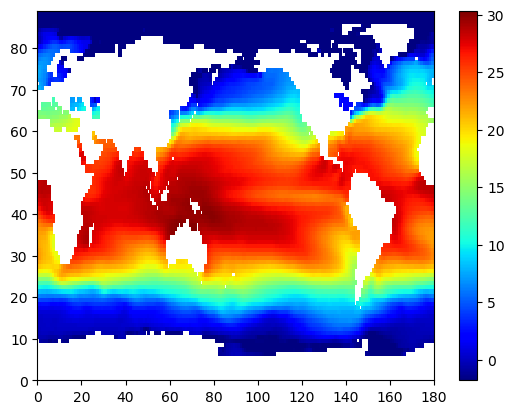

In [5]:
close(ds)
pcolor(temp'); colorbar();

In [6]:
size(temp)

(180, 89)

In [7]:
temp[100,20]

10.866639f0

Download all data (this will take some time)

In [8]:
SST = allowmissing(zeros(180, 89,length(URLs)));

for i = 1:length(URLs)
    println("load ",URLs[i])
    ds = Dataset(URLs[i])
    temp = ds["sst"][:,:,1,1]
    close(ds)
    
    SST[:,:,i] = temp;
end

load https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/01/ersst.v5.199901.nc
load https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/02/ersst.v5.199902.nc
load https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/03/ersst.v5.199903.nc
load https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/04/ersst.v5.199904.nc
load https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/05/ersst.v5.199905.nc
load https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/06/ersst.v5.199906.nc
load https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/07/ersst.v5.199907.nc
load https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v5/monthly/netcdf/1999/08/ersst.v5.199908.nc
load https://podaac-opendap.jpl.nasa.gov/opendap/allData/ersst/L4/ncei/v

check the size

In [9]:
size(SST)

(180, 89, 24)

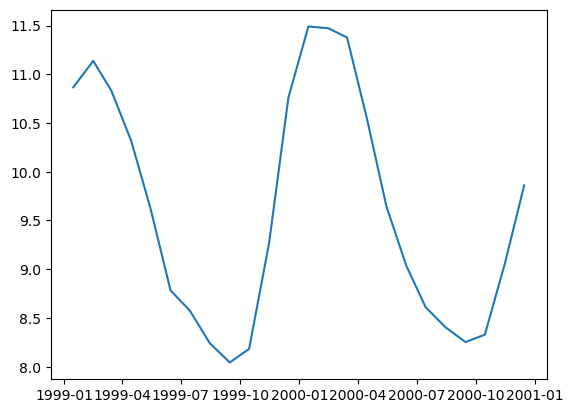

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f958c84e2b0>

In [10]:
plot(DateTime.(ssttime),SST[100,20,:])

In [11]:
# y ≈ a + b*x
function linear_regression(x,y)
    xm = mean(x)
    ym = mean(y)
    ss_xx = sum((x .- xm).^2)
    ss_yy = sum((y .- ym).^2)
    ss_xy = sum((x .- xm) .* (y .- ym))
    b = ss_xy / ss_xx
    a = ym - b * xm
    r2 = ss_xy^2 / (ss_xx*ss_yy)
    return a,b,r2
end

linear_regression (generic function with 1 method)

In [12]:
x = [0,1,2]
y = 1 .+ 3 * x
a,b,r2 = linear_regression(x,y)

(1.0, 3.0, 1.0)

In [13]:
yeartime = Dates.value.(ssttime) / (1000 * 60 * 60 * 24 * 365.25);

linear_regression(yeartime,SST[100,20,:])

(1167.4248070108097, -0.5792084802910347, 0.08114268817113769)

In [14]:
a = allowmissing(zeros(180, 89))
b = allowmissing(zeros(180, 89))
r2 = allowmissing(zeros(180, 89))

for i = 1:180
    for j = 1:89
      a[i,j],b[i,j],r2[i,j] = linear_regression(yeartime,SST[i,j,:])
    end
end

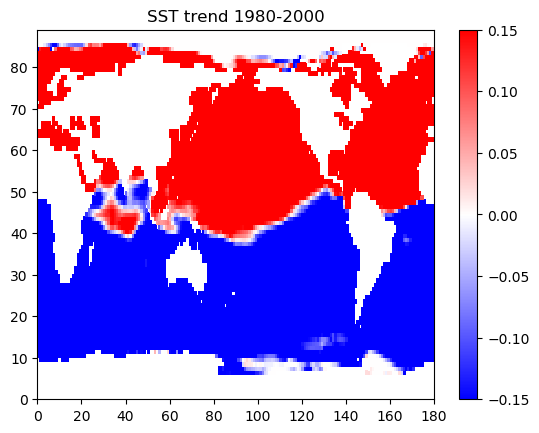

In [15]:
pcolor(b'; cmap="bwr");  colorbar(); clim(-0.15,0.15)
title("SST trend 1980-2000");


Note: better compute first the annual mean